<h1>[문제1]Fashion MNIST 데이터 정규화를 위한 Mean과 Std 값 찾기

In [2]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn, optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

In [3]:
base_path = os.path.join(os.path.pardir, 'data', 'fashion_mnist')
print(base_path)

..\data\fashion_mnist


In [3]:
fashion_mnist_dataset = datasets.FashionMNIST(base_path, train=True, download=True, transform=transforms.ToTensor())

100% 26421880/26421880 [00:03<00:00, 6639572.51it/s] 


Extracting ../data/fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/fashion_mnist/FashionMNIST/raw



100% 29515/29515 [00:00<00:00, 106709.98it/s]


Extracting ../data/fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/fashion_mnist/FashionMNIST/raw



100% 4422102/4422102 [00:03<00:00, 1368901.66it/s]


Extracting ../data/fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/fashion_mnist/FashionMNIST/raw



100% 5148/5148 [00:00<00:00, 14112599.34it/s]

Extracting ../data/fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/fashion_mnist/FashionMNIST/raw



In [4]:
all_images = torch.cat([fashion_mnist_dataset[i][0] for i in range(len(fashion_mnist_dataset))], dim=0)

# 평균과 표준편차 계산
mean = all_images.mean().item()
std = all_images.std().item()

In [5]:
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: 0.28604060411453247
Standard Deviation: 0.3530242443084717


Mean은 0.2860..., Std는 0.3530...

<H1>[문제2]Fashion MNIST 데이터에 대하여 CNN학습 시키기

In [4]:
#fashion_mnist데이터 불러오기 
def get_fashion_mnist_data():
    
    #fashion mnist traindata를 불러오기
    f_mnist_train = datasets.FashionMNIST(base_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])
    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape:", f_mnist_train[0][0].shape)
    def get_num_cpu_cores():
        import multiprocessing
        return multiprocessing.cpu_count()
    num_data_loading_workers = get_num_cpu_cores()
    
    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )
    
    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size, shuffle=False,
        pin_memory=True, num_workers=num_data_loading_workers
    )
    
    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3530),
    )
    return train_data_loader, validation_data_loader, f_mnist_transforms

In [5]:
#fashion_test데이터 불러오기
def get_fashion_mnist_test_data():
    f_mnist_test_images = datasets.FashionMNIST(base_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(base_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3530),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [8]:
config = {
    'batch_size': 2048,
}
wandb.init(mode='disabled',config=config)
train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data() 
print()
f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape: torch.Size([1, 28, 28])

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


In [9]:
from torchinfo import summary

In [10]:
 #가장 기본적인 모델 
class FirstModel(nn.Module):
    def __init__(self, in_channels, n_output=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.LazyConv2d(out_channels=64,kernel_size=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.LazyLinear(out_features=n_output),
            nn.Softmax()
        )
    def forward(self, X):
        X = self.model(X)
        return X
#모델 가져오는 함수
def get_cnn_model():
    model = FirstModel(in_channels=1)
    return model

In [11]:
from string import Template
#제공된 DeltaTemplate 사용
class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)
    
def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

In [12]:
#제공된 EarlyStopping클래스 사용
class EarlyStopping:

    def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
        self.patience = patience
        self.counter = 0
        self.delta = delta

        self.val_loss_min = None
        self.file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
        )
        self.latest_file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
        )

    def check_and_save(self, new_validation_loss, model):
        early_stop = False

        if self.val_loss_min is None:
            self.val_loss_min = new_validation_loss
            message = f'Early stopping is stated!'
        elif new_validation_loss < self.val_loss_min - self.delta:
            message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
            self.save_checkpoint(new_validation_loss, model)
            self.val_loss_min = new_validation_loss
            self.counter = 0
        else:
            self.counter += 1
            message = f'Early stopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                early_stop = True
                message += " *** TRAIN EARLY STOPPED! ***"

        return message, early_stop

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.file_path)
        torch.save(model.state_dict(), self.latest_file_path)
        self.val_loss_min = val_loss

In [13]:
from datetime import datetime
#제공된 ClassificationTrainer클래스를 조금 수정해서 사용
class Trainer:
    def __init__(self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms, run_time_str, wandb, device, checkpoint_file_path):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path
        
        self.loss_fn = nn.CrossEntropyLoss()
    
    def do_train(self):
        self.model.train()
        train_loss = 0.0
        num_trains = 0
        num_correct = 0
        num_trained_samples = 0
        for images, labels in self.train_data_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            if self.transforms:
                images = self.transforms(images)
            
            train_output = self.model(images)
            loss = self.loss_fn(train_output, labels)
            
            train_loss += loss.item()
            train_predited = torch.argmax(train_output, dim=-1)
            #Accuracy를 구하기위해서 label과 predicted 맞힌 개수
            num_correct += (train_predited == labels).sum().item()
            num_trained_samples += len(images)
            num_trains += 1
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        train_loss /= num_trains
        train_accuracy = 100 * num_correct / num_trained_samples
        return train_loss, train_accuracy
    def do_validation(self):
        self.model.eval()
        
        validation_loss = 0.0
        num_validations = 0
        num_correct = 0
        num_validation_samples = 0
        for images, labels in self.validation_data_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            if self.transforms:
                images = self.transforms(images)
            output_validation = self.model(images)
            validation_loss += self.loss_fn(output_validation, labels).item()
            _, predicted = torch.max(output_validation.data, 1)
            num_validation_samples += labels.size(0)
            num_correct += (predicted == labels).sum().item()
            num_validations+=1
        
        validation_loss /= num_validations
        validation_accuracy = 100 * num_correct / num_validation_samples
        
        return validation_loss, validation_accuracy
    
    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str,
        )
        num_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()
        for epoch in range(1,num_epochs+1):
            train_loss, train_accuracy = self.do_train()
            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()
                
                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time == 0 else epoch / elapsed_time.seconds
                
                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)
                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"T_accuracy: {train_accuracy:6.4f} | "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"V_accuracy: {validation_accuracy:6.4f} | "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )
                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Training accuracy": train_accuracy,
                    "Validation loss": validation_loss,
                    "Validation accuracy (%)": validation_accuracy,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })
                if early_stop:
                    break
        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

In [14]:
import wandb
wandb.login()

True

In [28]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
#하이퍼 파라미터 설정
config = {
    'epochs': 1000, #epoch는 1000
    'batch_size': 128,
    'validation_intervals': 10, #train 5번당 validation1번
    'learning_rate': 0.001, #learning rate는 0.001
    'early_stop_patience': 10, #더이상 validation loss가 10번동안 줄지 않으면 학습 중지
    'early_stop_delta': 0.0001 
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #gpu 사용가능 여부 체크
project_name = 'Fashion_MNIST'

In [20]:
class FirstModel_addDropout(nn.Module):
    def __init__(self, in_channels, n_output=10):
        super().__init__()
        # 컨볼루션 층 2번 리니어층 1번하는 모델
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.LazyConv2d(out_channels=64,kernel_size=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Flatten(),
            #기본 모델에 Dropout을 추가함
            nn.Dropout(0.5), 
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.LazyLinear(out_features=n_output),
            #기본 모델에 Dropout을 추가함
            nn.Dropout(0.5),
            nn.Softmax()
        )
    def forward(self, X):
        X = self.model(X)
        return X
def get_fisrtmodel_addDropout():
    return FirstModel_addDropout(in_channels=1, n_output=10)

In [23]:
#모델을 저장하기위한 path
first_model_addDropout_path = os.path.join('checkpoint_dropout')
name = 'firstmodel_addDropout'
wandb.init(
    mode='online',
    project=project_name,
    notes='Fashion_MNIST with various models',
    name=name,
    config=config,
)
#모델 불러오는 함수 호출
dropout_model = get_fisrtmodel_addDropout()
dropout_model.to(device)
#adam optimizer를 사용
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=wandb.config.learning_rate)
classification_trainer = Trainer(
    project_name=project_name,model=dropout_model, optimizer=optimizer,train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=f_mnist_transforms, run_time_str=run_time_str,wandb=wandb,device=device,checkpoint_file_path=first_model_addDropout_path
)
#학습 시작
classification_trainer.train_loop()
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch   1] T_loss: 2.06943, T_accuracy: 38.0073 | V_loss: 1.72327, V_accuracy: 75.2800 | Early stopping is stated! | T_time: 00:00:04, T_speed: 0.250
[Epoch   5] T_loss: 1.93145, T_accuracy: 50.7200 | V_loss: 1.62567, V_accuracy: 84.8000 | V_loss decreased (1.72327 --> 1.62567). Saving model... | T_time: 00:00:14, T_speed: 0.357
[Epoch  10] T_loss: 1.91426, T_accuracy: 52.3509 | V_loss: 1.59557, V_accuracy: 87.0600 | V_loss decreased (1.62567 --> 1.59557). Saving model... | T_time: 00:00:27, T_speed: 0.370
[Epoch  15] T_loss: 1.90663, T_accuracy: 53.0891 | V_loss: 1.58598, V_accuracy: 87.7800 | V_loss decreased (1.59557 --> 1.58598). Saving model... | T_time: 00:00:40, T_speed: 0.375
[Epoch  20] T_loss: 1.90253, T_accuracy: 53.4673 | V_loss: 1.58144, V_accuracy: 88.5000 | V_loss decreased (1.58598 --> 1.58144). Saving model... | T_time: 00:00:53, T_speed: 0.377
[Epoch  25] T_loss: 1.90076, T_accuracy: 53.3855 | V_loss: 1.56974, V_accuracy: 89.4400 | V_loss decreased (1.58144 --> 1.569

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████▇████████████
Training loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▇▇▇████████████████████████████████████
Validation accuracy (%),▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
Validation loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,205
Training accuracy,57.32
Training loss,1.8608
Training speed (epochs/sec.),0.38462
Validation accuracy (%),92.96


In [25]:
summary(model=dropout_model, input_size=(1, 1, 28, 28),
        col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"], dtypes=[torch.float] )

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
FirstModel_addDropout                    --                        [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 1, 28, 28]            [1, 10]                   --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 1, 28, 28]            [1, 64, 26, 26]           640                       432,640
│    └─MaxPool2d: 2-2                    [2, 2]                    [1, 64, 26, 26]           [1, 64, 13, 13]           --                        --
│    └─ReLU: 2-3                         --                        [1, 64, 13, 13]           [1, 64, 13, 13]           --                        --
│    └─Conv2d: 2-4                       [3, 3]                    [1, 64, 13, 13]           [1, 64,

In [29]:
def get_resnet_model():
    class Residual(nn.Module):
        def __init__(self, num_channels, use_1x1conv=False, strides=1):
            super().__init__()
            self.conv1 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, padding=1, stride=strides)
            self.conv2 = nn.LazyConv2d(out_channels=num_channels, kernel_size=3, padding=1)
            if use_1x1conv:
                self.conv3 = nn.LazyConv2d(out_channels=num_channels, kernel_size=1, stride=strides)
            else:
                self.conv3 = None
            self.bn1 = nn.LazyBatchNorm2d()
            self.bn2 = nn.LazyBatchNorm2d()

        def forward(self, X):
            Y = torch.relu(self.bn1(self.conv1(X)))
            Y = self.bn2(self.conv2(Y))
            if self.conv3:
                X = self.conv3(X)
            Y += X
            return torch.relu(Y)

    class ResNet(nn.Module):
        def __init__(self, arch, n_outputs=10):
            super(ResNet, self).__init__()
            self.model = nn.Sequential(
                nn.Sequential(
                    nn.LazyConv2d(out_channels=64, kernel_size=7, stride=2, padding=3),
                    nn.LazyBatchNorm2d(),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                )
            )

            # Add residual blocks
            for i, (num_residuals, num_channels) in enumerate(arch):
                self.model.add_module(
                    name=f'block_{i}', 
                    module=self.block(num_residuals, num_channels, first_block=(i == 0))
                )
            
            # Add the final classification layers
            self.model.add_module(
                name='last',
                module=nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Dropout(0.25),
                    nn.LazyLinear(n_outputs),
                )
            )

        def block(self, num_residuals, num_channels, first_block=False):
            blk = []
            for i in range(num_residuals):
                if i == 0 and not first_block:
                    blk.append(Residual(num_channels=num_channels, use_1x1conv=True, strides=2))
                else:
                    blk.append(Residual(num_channels=num_channels))
            return nn.Sequential(*blk)

        def forward(self, x):
            return self.model(x)

    my_model = ResNet(arch=((2, 64), (2, 128), (2, 256), (2, 512)), n_outputs=10)

    return my_model

In [30]:
name = 'ResnetModel'
wandb.init(
    mode='online',
    project=project_name,
    notes='Fashion_MNIST with various models',
    name=name,
    config=config,
)
Resnet_model = get_resnet_model()
Resnet_model.to(device)
optimizer = torch.optim.Adam(Resnet_model.parameters(), lr=wandb.config.learning_rate)
Resnet_checkout = os.path.join('checkpoint_resnet')
classification_trainer = Trainer(
    project_name=project_name,model=Resnet_model, optimizer=optimizer,train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=f_mnist_transforms, run_time_str=run_time_str,wandb=wandb,device=device,checkpoint_file_path=Resnet_checkout
)
classification_trainer.train_loop()
wandb.finish()

[Epoch   1] T_loss: 0.78017, T_accuracy: 72.6764 | V_loss: 0.67305, V_accuracy: 77.0000 | Early stopping is stated! | T_time: 00:00:04, T_speed: 0.250
[Epoch  10] T_loss: 0.17812, T_accuracy: 93.2891 | V_loss: 0.31496, V_accuracy: 88.7200 | V_loss decreased (0.67305 --> 0.31496). Saving model... | T_time: 00:00:41, T_speed: 0.244
[Epoch  20] T_loss: 0.10044, T_accuracy: 96.1782 | V_loss: 0.36200, V_accuracy: 89.0400 | Early stopping counter: 1 out of 10 | T_time: 00:01:23, T_speed: 0.241
[Epoch  30] T_loss: 0.06360, T_accuracy: 97.5782 | V_loss: 0.38660, V_accuracy: 89.7400 | Early stopping counter: 2 out of 10 | T_time: 00:02:05, T_speed: 0.240
[Epoch  40] T_loss: 0.03995, T_accuracy: 98.5036 | V_loss: 0.38108, V_accuracy: 90.7200 | Early stopping counter: 3 out of 10 | T_time: 00:02:46, T_speed: 0.241
[Epoch  50] T_loss: 0.02596, T_accuracy: 99.0164 | V_loss: 0.48603, V_accuracy: 90.1400 | Early stopping counter: 4 out of 10 | T_time: 00:03:28, T_speed: 0.240
[Epoch  60] T_loss: 0.02

Epoch,▁▂▂▃▄▄▅▅▆▇▇█
Training accuracy,▁▆▇▇████████
Training loss,█▃▂▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▄▂▁▂▁▂▁▂▂▂▂
Validation accuracy (%),▁▇▇▇██▇██▇██
Validation loss,█▁▂▂▂▄▄▄▅▅▃▄
Epoch,110
Training accuracy,99.55636
Training loss,0.01338
Training speed (epochs/sec.),0.24123
Validation accuracy (%),90.98


In [32]:
class second_model(nn.Module):
    def __init__(self, input_channels = 1, n_output=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(out_channels=32, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.LazyConv2d(out_channels=64, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.25),
            nn.LazyLinear(n_output),
            nn.Softmax(),
        )
    def forward(self, x):
        x = self.model(x)
        return x

def get_second_model():
    model = second_model()
    return model

In [33]:
name = 'second_model'
wandb.init(
    mode='online',
    project=project_name,
    notes='Fashion_MNIST with various models',
    name=name,
    config=config,
)
second_model_test = get_second_model()
second_model_test.to(device)
#Adam 옵티마이저 사용(beta1 = 0.9, beta2 = 0.999)
optimizer = torch.optim.Adam(second_model_test.parameters(), lr=wandb.config.learning_rate, betas=(0.9, 0.999))
#딥러닝 모델 저장 path
second_checkout = os.path.join('checkpoint_second')
#Trainer 객체 생성
classification_trainer = Trainer(
    project_name=project_name,model=second_model_test, optimizer=optimizer,train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=f_mnist_transforms, run_time_str=run_time_str,wandb=wandb,device=device,checkpoint_file_path=second_checkout
)
#학습 시작
classification_trainer.train_loop()
wandb.finish()

[Epoch   1] T_loss: 1.80080, T_accuracy: 71.6764 | V_loss: 1.74983, V_accuracy: 79.8600 | Early stopping is stated! | T_time: 00:00:02, T_speed: 0.500
[Epoch  10] T_loss: 1.56010, T_accuracy: 90.6655 | V_loss: 1.55858, V_accuracy: 90.6400 | V_loss decreased (1.74983 --> 1.55858). Saving model... | T_time: 00:00:25, T_speed: 0.400
[Epoch  20] T_loss: 1.54244, T_accuracy: 92.2000 | V_loss: 1.55332, V_accuracy: 91.0000 | V_loss decreased (1.55858 --> 1.55332). Saving model... | T_time: 00:00:51, T_speed: 0.392
[Epoch  30] T_loss: 1.53213, T_accuracy: 93.2255 | V_loss: 1.54804, V_accuracy: 91.3800 | V_loss decreased (1.55332 --> 1.54804). Saving model... | T_time: 00:01:16, T_speed: 0.395
[Epoch  40] T_loss: 1.52385, T_accuracy: 93.9982 | V_loss: 1.53840, V_accuracy: 92.6200 | V_loss decreased (1.54804 --> 1.53840). Saving model... | T_time: 00:01:42, T_speed: 0.392
[Epoch  50] T_loss: 1.51854, T_accuracy: 94.5182 | V_loss: 1.53509, V_accuracy: 92.6400 | V_loss decreased (1.53840 --> 1.535

Epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Training accuracy,▁▆▇▇▇▇▇▇▇▇██████████████████
Training loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▁▇▇▇███▇█▇██████████████████
Validation loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,270
Training accuracy,97.45636
Training loss,1.48762
Training speed (epochs/sec.),0.39531
Validation accuracy (%),93.2


In [34]:
summary(model=second_model_test, input_size=(1, 1, 28, 28),
        col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"], dtypes=[torch.float] )

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
second_model                             --                        [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 1, 28, 28]            [1, 10]                   --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 1, 28, 28]            [1, 32, 26, 26]           320                       216,320
│    └─ReLU: 2-2                         --                        [1, 32, 26, 26]           [1, 32, 26, 26]           --                        --
│    └─BatchNorm2d: 2-3                  --                        [1, 32, 26, 26]           [1, 32, 26, 26]           64                        64
│    └─Dropout: 2-4                      --                        [1, 32, 26, 26]           [1, 32,

In [6]:
class third_model(nn.Module):
    def __init__(self, input_channels = 1, n_output=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Dropout(0.3),
            nn.LazyConv2d(out_channels=32, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Dropout(0.3),
            nn.LazyConv2d(out_channels=64, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=1),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.LazyLinear(out_features=512),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.5),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.5),
            nn.LazyLinear(n_output),
            nn.Softmax(),
            
        )
    def forward(self, x):
        x = self.model(x)
        return x
            
    
def get_third_model():
    model = third_model()
    return model

In [36]:
name = 'third_model'
wandb.init(
    mode='online',
    project=project_name,
    notes='Fashion_MNIST with various models',
    name=name,
    config=config,
)
third_model_test = get_third_model()
third_model_test.to(device)
#Adam 옵티마이저 사용(beta1 = 0.9, beta2 = 0.999)
optimizer = torch.optim.Adam(third_model_test.parameters(), lr=wandb.config.learning_rate, betas=(0.9, 0.999))
#딥러닝 모델 저장하기 위한 path
third_checkout = os.path.join('checkpoint_third')
#Trainer 객체 생성
classification_trainer = Trainer(
    project_name=project_name,model=third_model_test, optimizer=optimizer,train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=f_mnist_transforms, run_time_str=run_time_str,wandb=wandb,device=device,checkpoint_file_path=third_checkout
)
#학습 시작
classification_trainer.train_loop()
wandb.finish()

[Epoch   1] T_loss: 1.78634, T_accuracy: 72.9036 | V_loss: 1.79341, V_accuracy: 72.6400 | Early stopping is stated! | T_time: 00:00:03, T_speed: 0.333
[Epoch  10] T_loss: 1.54912, T_accuracy: 91.6382 | V_loss: 1.54510, V_accuracy: 91.7000 | V_loss decreased (1.79341 --> 1.54510). Saving model... | T_time: 00:00:28, T_speed: 0.357
[Epoch  20] T_loss: 1.52697, T_accuracy: 93.6455 | V_loss: 1.53253, V_accuracy: 93.0000 | V_loss decreased (1.54510 --> 1.53253). Saving model... | T_time: 00:00:56, T_speed: 0.357
[Epoch  30] T_loss: 1.51625, T_accuracy: 94.6745 | V_loss: 1.53285, V_accuracy: 92.8800 | Early stopping counter: 1 out of 10 | T_time: 00:01:24, T_speed: 0.357
[Epoch  40] T_loss: 1.50851, T_accuracy: 95.4200 | V_loss: 1.52623, V_accuracy: 93.5200 | V_loss decreased (1.53253 --> 1.52623). Saving model... | T_time: 00:01:52, T_speed: 0.357
[Epoch  50] T_loss: 1.50158, T_accuracy: 96.0455 | V_loss: 1.52554, V_accuracy: 93.6200 | V_loss decreased (1.52623 --> 1.52554). Saving model...

Epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
Training accuracy,▁▆▇▇▇▇▇██▇██████████████
Training loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▇██████████████████████
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,230
Training accuracy,98.82545
Training loss,1.47314
Training speed (epochs/sec.),0.35385
Validation accuracy (%),94.04


In [37]:
summary(model=second_model_test, input_size=(1, 1, 28, 28),
        col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"], dtypes=[torch.float] )

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
second_model                             --                        [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 1, 28, 28]            [1, 10]                   --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 1, 28, 28]            [1, 32, 26, 26]           320                       216,320
│    └─ReLU: 2-2                         --                        [1, 32, 26, 26]           [1, 32, 26, 26]           --                        --
│    └─BatchNorm2d: 2-3                  --                        [1, 32, 26, 26]           [1, 32, 26, 26]           64                        64
│    └─Dropout: 2-4                      --                        [1, 32, 26, 26]           [1, 32,

### Learning Rate는 0.001    
### Batch Size는 128개  
### Early Stop Patience의 경우 validation이 10번동안 안떨어지면 종료하도록함
### Weight_decay는 사용하지 않았습니다.
### Normalization은 매 컨볼루션 층에는 Relu 후에 BatchNormalization 2d가 사용되었고 Linear에서는 마지막 10개의 채널 구하기 전에 BatchNormalization 1d를 사용하였습니다.
### Dropout의 경우 매 컨볼루션 층에서 0.3을 주고 Flatten이후에는 LinearLayout에서는 0.5를 주었습니다. 
### 추가적으로 optimizer는 Adam을 사용했고 beta1 = 0.9, beta2 = 0.999를 사용했습니다. 
### Validation Accuracy 94.04가 나왔습니다.

<H1>[문제 3]학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

In [1]:
import matplotlib.pyplot as plt
#ClassificationTester를 참고하여 tester클래서 정의

class Tester:
    def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
        self.project_name = project_name
        self.test_data_loader = test_data_loader
        self.transforms = transforms
        self.latest_file_path = os.path.join(checkpoint_file_path, f'{project_name}_checkpoint_latest.pt')
        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        
        print("MODEL FILE: {0}".format(self.latest_file_path))
        
        self.model.load_state_dict(torch.load(self.latest_file_path, map_location=self.device))
        self.all_images = []
        self.all_labels = []
        self.all_predictions = []
    
    def test(self):
        self.model.eval()
        num_correct = 0
        num_tested_samples = 0
        
        with torch.no_grad():
            for images, labels in self.test_data_loader:
                if self.transforms:
                    images = self.transforms(images)
                
                test_output = self.model(images)
                test_predicted = torch.argmax(test_output, dim=-1)
                num_correct += (test_predicted == labels).sum().item()
                num_tested_samples += len(labels)
                #이미지 저장해주기 
                self.all_images.append(images.cpu())
                self.all_labels.append(labels.cpu())
                self.all_predictions.append(test_predicted.cpu())
                
            test_accuracy = 100.0 * num_correct / num_tested_samples
        
        print(f"Test Accuracy: {test_accuracy:.2f}%")
    def visualize_random_predictions(self):
        #label index별 이름
        label_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        #모든 image, label, predicted_label를 0차원을 기준으로 합치기
        images = torch.cat(self.all_images, dim=0)
        labels = torch.cat(self.all_labels, dim=0)
        predictions = torch.cat(self.all_predictions, dim=0)

        #random 하게 10개 선택
        indices = torch.randperm(len(images))[:10]
        #선택된 이미지들 라스트 저장
        selected_images = images[indices]
        selected_labels = labels[indices]
        selected_predictions = predictions[indices]

        # Plot the samples
        fig, axes = plt.subplots(1, 10, figsize=(20, 3))
        for i, ax in enumerate(axes):
            #channel demension을 없애기 위해 squeeze()함수 실행
            img = selected_images[i].squeeze().numpy()  
            #아까 만든 label 이름과 선택된 prediction과 매칭
            predicted_name = label_names[selected_predictions[i].item()]
            #아까 만든 label 이름과 선택된 실제 label과 매칭
            actual_name = label_names[selected_labels[i].item()]
            #이미지 10개 보여주기
            ax.imshow(img, cmap='gray')
            ax.set_title(f"P: {predicted_name}\nL: {actual_name}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [8]:
f_mnist_test_images, f_mnist_test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()
third_checkout = os.path.join('checkpoint_third')
project_name = 'Fashion_MNIST'
test_model = get_third_model()
classification_Tester = Tester(project_name, test_model, f_mnist_test_data_loader, f_mnist_transforms, third_checkout)
classification_Tester.test()

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: checkpoint_third\Fashion_MNIST_checkpoint_latest.pt


C:\Users\Jinsung\AppData\Local\Temp\ipykernel_13660\657986583.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.latest_file_pat

Test Accuracy: 93.33%


<H3> Test Accuracy: 93.33%가 나왔습니다

<H1>[문제 4]샘플 테스트 데이터 분류 예측 결과 확인하기 

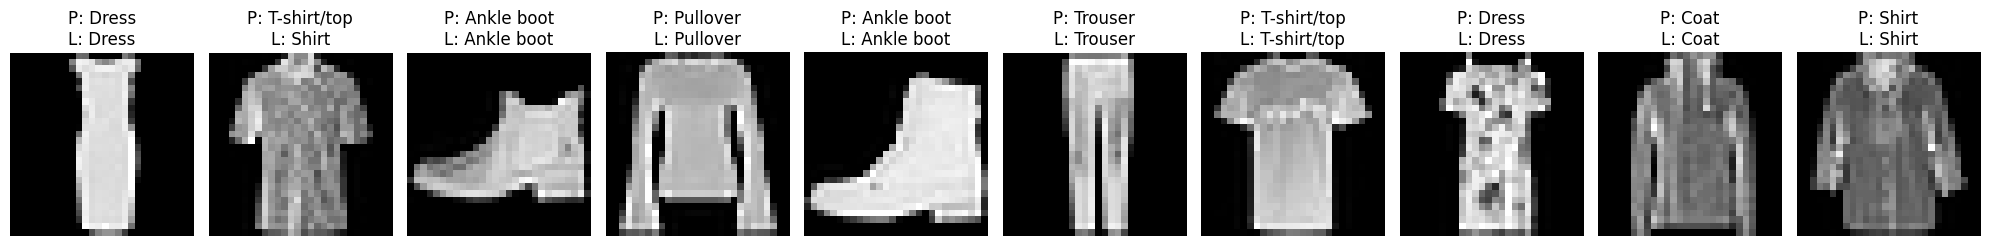

In [10]:
classification_Tester.visualize_random_predictions()

<h4>2번째 있는 것이 기존 label이 Shirt인데 T-Shirt/top로 나왔는데 육안으로 확인해도 shirt보다는 T-shirt라고 생각이 들 정도로 화질이 좋지 않아서 Shirt와 T-Shirt/top에 대한 구분을 확실하게 하지 못한것 같습니다. 또한 전반적으로fashion_mnist의 pixel이 28*28이다 보니 화질이 좋지않아서 상의 계열, 하의 계열, 신발 계열등은 잘 분리하는데 상의 계열 내부적으로는 구분을 정확히 하기 힘들것 같습니다. 이 경우의 화질이 조금은 더 좋은 데이터로 학습을 한다면 이보다 더 구분을 잘할 수 있다고 생각합니다.

<H1>숙제 후기

이번 과제를 진행하면서 하이퍼 파라미터 조정하는게 딥러닝에서 엄청나게 중요하구나라는 것을 알았습니다. 실제로 같은 모델에서도 하이퍼파라미터를 변경을 자주 진행하였습니다. 그리고 또한 Dropout, BatchNormalization을 주는 위치, 강도등을 변경을 하면서도 진행했는데 확실히 성능이 큰폭으로 변화가 있었습니다. 이번에는 backend ai환경에서 진행했는데 집에서 3080쓰고 학습을 진행해봤는데 너무 오래걸려서 중간에 중단한 적도 있습니다. 확실히 이번에 학교에서 제공해준 환경이 많은 도움과 시간 단축이 되었습니다. 이 Fashion MNIST는 실제 사진보다는 feature가 많지 않아서 그런지 다른 ResNet, Vgg같은 것을 써보았는데 확실히 성능이 좋지 않았습니다. 그래서 Fashion MNIST는 흑백이미지이지만 다른 색 이미지에 화질이 조금 더 많은 이미지를 통해서 학습을 해보면 더 좋을 것 같습니다.